<a href="https://www.kaggle.com/code/mahmoudabdrabo17/brain-tumor-cnn-mobilenetv2?scriptVersionId=222874206" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# from google.colab import files
# files.upload()

In [2]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

## Imports

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
import PIL
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

## Loading the Data

In [3]:

!kaggle datasets download masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 86%|███████████████████████████████████▎     | 128M/149M [00:00<00:00, 338MB/s]
100%|█████████████████████████████████████████| 149M/149M [00:00<00:00, 340MB/s]


In [4]:
!unzip /kaggle/working/brain-tumor-mri-dataset.zip

Archive:  /kaggle/working/brain-tumor-mri-dataset.zip
  inflating: Testing/glioma/Te-glTr_0000.jpg  
  inflating: Testing/glioma/Te-glTr_0001.jpg  
  inflating: Testing/glioma/Te-glTr_0002.jpg  
  inflating: Testing/glioma/Te-glTr_0003.jpg  
  inflating: Testing/glioma/Te-glTr_0004.jpg  
  inflating: Testing/glioma/Te-glTr_0005.jpg  
  inflating: Testing/glioma/Te-glTr_0006.jpg  
  inflating: Testing/glioma/Te-glTr_0007.jpg  
  inflating: Testing/glioma/Te-glTr_0008.jpg  
  inflating: Testing/glioma/Te-glTr_0009.jpg  
  inflating: Testing/glioma/Te-gl_0010.jpg  
  inflating: Testing/glioma/Te-gl_0011.jpg  
  inflating: Testing/glioma/Te-gl_0012.jpg  
  inflating: Testing/glioma/Te-gl_0013.jpg  
  inflating: Testing/glioma/Te-gl_0014.jpg  
  inflating: Testing/glioma/Te-gl_0015.jpg  
  inflating: Testing/glioma/Te-gl_0016.jpg  
  inflating: Testing/glioma/Te-gl_0017.jpg  
  inflating: Testing/glioma/Te-gl_0018.jpg  
  inflating: Testing/glioma/Te-gl_0019.jpg  
  inflating: Testing/gliom

In [7]:
# train_dir = '/content/Training'
# test_dir = '/content/Testing'

train_dir = '/kaggle/working/Training'
test_dir = '/kaggle/working/Testing'

## Data Generator

In [8]:
data_gen1=ImageDataGenerator(rescale=1/255,
                             rotation_range=10,
                             width_shift_range=0.02,
                             height_shift_range=0.05,
                             shear_range=0.02,
                             zoom_range=0.05,
                             validation_split=0.2,
                             horizontal_flip=False,
                             vertical_flip=False,
                             fill_mode='nearest'
                             )

print('Data Augmentation 1 was created')

data_gen2=ImageDataGenerator(rescale=1/255,
                             rotation_range=5,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.1,
                             zoom_range=0.1,
                             horizontal_flip=False,
                             vertical_flip=False,
                             fill_mode='nearest'
                             )
print('Data Augmentation 2 was created')
data_gen3=ImageDataGenerator(rescale=1/255)

Data Augmentation 1 was created
Data Augmentation 2 was created


In [11]:
train_genrator=data_gen1.flow_from_directory(
    directory=train_dir,
    color_mode='rgb',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,

    subset='training'
)
print('Data Augmentation 1 Was Used To Generate Training Data \n')

Found 4571 images belonging to 4 classes.
Data Augmentation 1 Was Used To Generate Training Data 



In [12]:
validation_genrator = data_gen1.flow_from_directory(
   directory=train_dir,
    color_mode='rgb',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32,
    subset='validation'
)

Found 1141 images belonging to 4 classes.


In [13]:
test_genrator=data_gen2.flow_from_directory(
    directory=test_dir,
    color_mode='rgb',
    target_size=(224,224),
    # class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    class_mode='categorical'

)
print('Data Augmentation 2 Was Used To Generate Testing Data \n')

Found 1311 images belonging to 4 classes.
Data Augmentation 2 Was Used To Generate Testing Data 



## Extracting Class Names

In [51]:
dict_name = train_genrator.class_indices
class_names = list(dict_name.keys())
print(f'class_names :{class_names}')

class_names :['glioma', 'meningioma', 'notumor', 'pituitary']


## Counting Objects in Each Class in Training Data

In [45]:
print('Number of Image Training :',len(train_genrator.classes))
for i in range(len(class_names)):
  print(f'{class_names[i]} : {Count_train_img[i]}')

Number of Image Training : 4571
glioma : 1057
meningioma : 1072
notumor : 1276
pituitary : 1166


In [17]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Bar(
    x=class_names,
    y=Count_train_img,
    text=Count_train_img,
    textposition='auto',
    marker=dict(color=['#636EFA', '#EF553B', '#00CC96', '#AB63FA'])
))
fig.update_layout(
    title="Count data training of Classes",
    xaxis=dict(title="Classes"),
    yaxis=dict(title="Count"),
    width=700,
    height=500
)
fig.show()


In [18]:
import plotly.graph_objects as go
total = sum(Count_train_img)
percentages = [(Count_train_img / total) * 100 for Count_train_img in Count_train_img]

fig = go.Figure()

fig.add_trace(go.Bar(
    x=class_names,
    y=percentages,
    text=[f'{p:.1f}%' for p in percentages],
    textposition='auto',
    marker=dict(color=['#636EFA', '#EF553B', '#00CC96', '#AB63FA'])
))
fig.update_layout(
    title="Percentage Distribution of Classes",
    xaxis=dict(title="Classes"),
    yaxis=dict(title="Percentage (%)"),
    width=700,
    height=500
)
fig.show()


## Counting Objects in Each Class in Test Data

In [48]:
print('Number of Image Testing :',len(test_genrator.classes),'\n')
for i in range(len(class_names)):
  print(f'{class_names[i]} : {Count_test_img[i]}')

Number of Image Testing : 1311 

glioma : 300
meningioma : 306
notumor : 405
pituitary : 300


In [79]:
fig = go.Figure()
fig.add_trace(go.Bar(
              x=class_names,
              y=Count_test_img,
              text=Count_test_img,
              textposition='auto',
              marker=dict(color=['#636EFA', '#EF553B', '#00CC96', '#AB63FA'])
))
fig.update_layout(
    title='Distribution Testing Classes',
    xaxis=dict(title='Classes'),
    yaxis=dict(title='Count'),
    width=700,
    height=500
)
fig.show()

## Displaying Random Sample Images

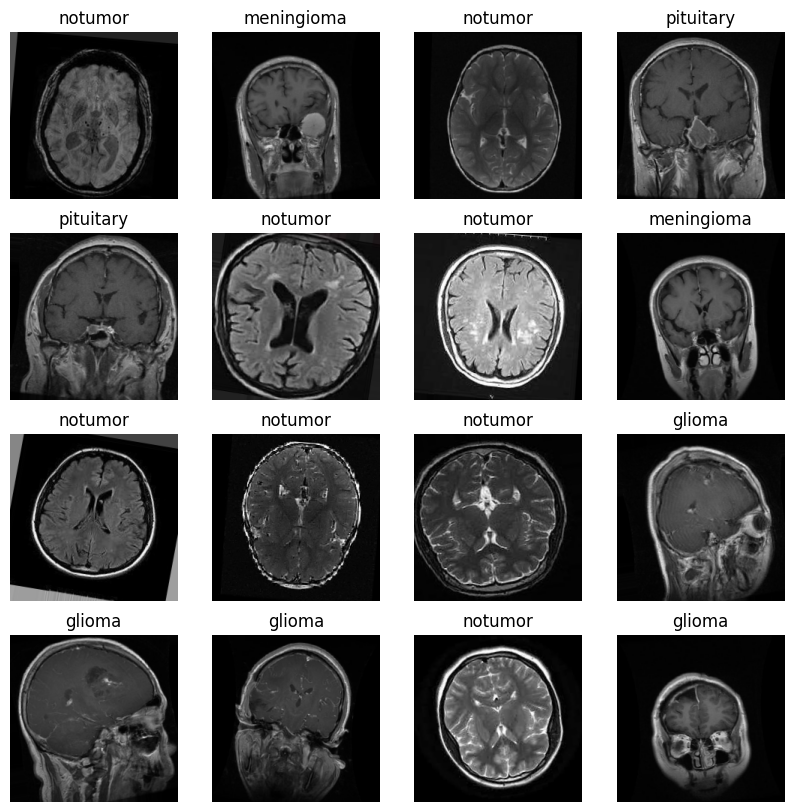

In [78]:
img, label = next(train_genrator)
plt.figure(figsize=(10,10))
for i in range(16):
  ax = plt.subplot(4,4,i+1)
  plt.imshow(img[i])
  plt.title(class_names[np.argmax(label[i])])
  plt.axis('off')

## Building CNN

In [35]:
model = models.Sequential([
    
    layers.Conv2D(filters=16,kernel_size=(3, 3),kernel_regularizer=L2(0.001), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),


    layers.Conv2D(filters=64,kernel_size=(3, 3), kernel_regularizer=L2(0.001),activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    
    layers.Flatten(),
    
    layers.Dense(200, activation='relu',kernel_regularizer=L2(0.001)),
    layers.Dense(100, activation='relu',kernel_regularizer=L2(0.001)),
    layers.Dense(200, activation='relu',kernel_regularizer=L2(0.001)),
    layers.Dropout(0.3),
    
    layers.Dense(4, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 111, 111, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 109, 109, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 54, 54, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 52, 52, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 26, 26, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 43264)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 200)                 │       8,653,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 100)                 │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 200)                 │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 4)                   │             804 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,718,136 (33.26 MB)

 Trainable params: 8,717,912 (33.26 MB)

 Non-trainable params: 224 (896.00 B)

In [36]:
checkpoint_path = "best_model.keras"
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1 )
early_stopping=EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)
rer=ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

#Train the model and Add the checkpoint callback
history = model.fit(
    train_genrator,
    validation_data=validation_genrator,
    epochs=50,
    batch_size=32,
    callbacks=[checkpoint,early_stopping,rer ]
)

Epoch 1/50
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.6350 - loss: 2.2216
Epoch 1: val_accuracy improved from -inf to 0.22612, saving model to best_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 74s 452ms/step - accuracy: 0.6361 - loss: 2.2176 - val_accuracy: 0.2261 - val_loss: 2.9044 - learning_rate: 0.0010
Epoch 2/50
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.8078 - loss: 1.5168
Epoch 2: val_accuracy improved from 0.22612 to 0.27432, saving model to best_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 60s 401ms/step - accuracy: 0.8081 - loss: 1.5156 - val_accuracy: 0.2743 - val_loss: 3.6499 - learning_rate: 0.0010
Epoch 3/50
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.8411 - loss: 1.2062
Epoch 3: val_accuracy improved from 0.27432 to 0.66959, saving model to best_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 58s 392ms/step - accuracy: 0.8413 - loss: 1.2051 - val_accuracy: 0.6696 - val_loss: 1.5227 - learning_rate: 0.0010
Epoch 4/50
142/143 ━━━━━━━━━━━━━━━━━━━━ 

In [38]:
loss, accuracy = model.evaluate(validation_genrator)
print(f'Loss: {loss}, Accuracy: {accuracy}')

36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 316ms/step - accuracy: 0.8504 - loss: 0.8263
Loss: 0.7840206623077393, Accuracy: 0.851007878780365


## Accuracy and Val_Accuracy 

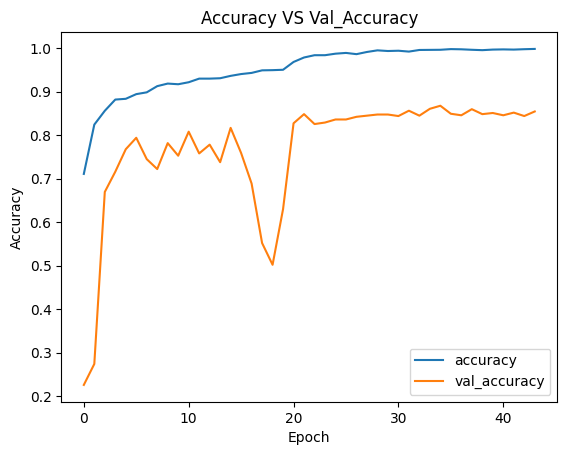

In [41]:
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy VS Val_Accuracy')
plt.legend()
plt.show()

## Loss and Val_Loss

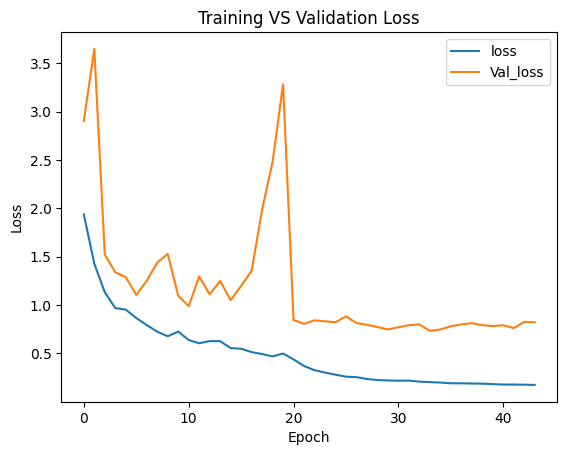

In [42]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='Val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training VS Validation Loss')
plt.legend()
plt.show()

## Comparing Model Predictions with True Labels

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


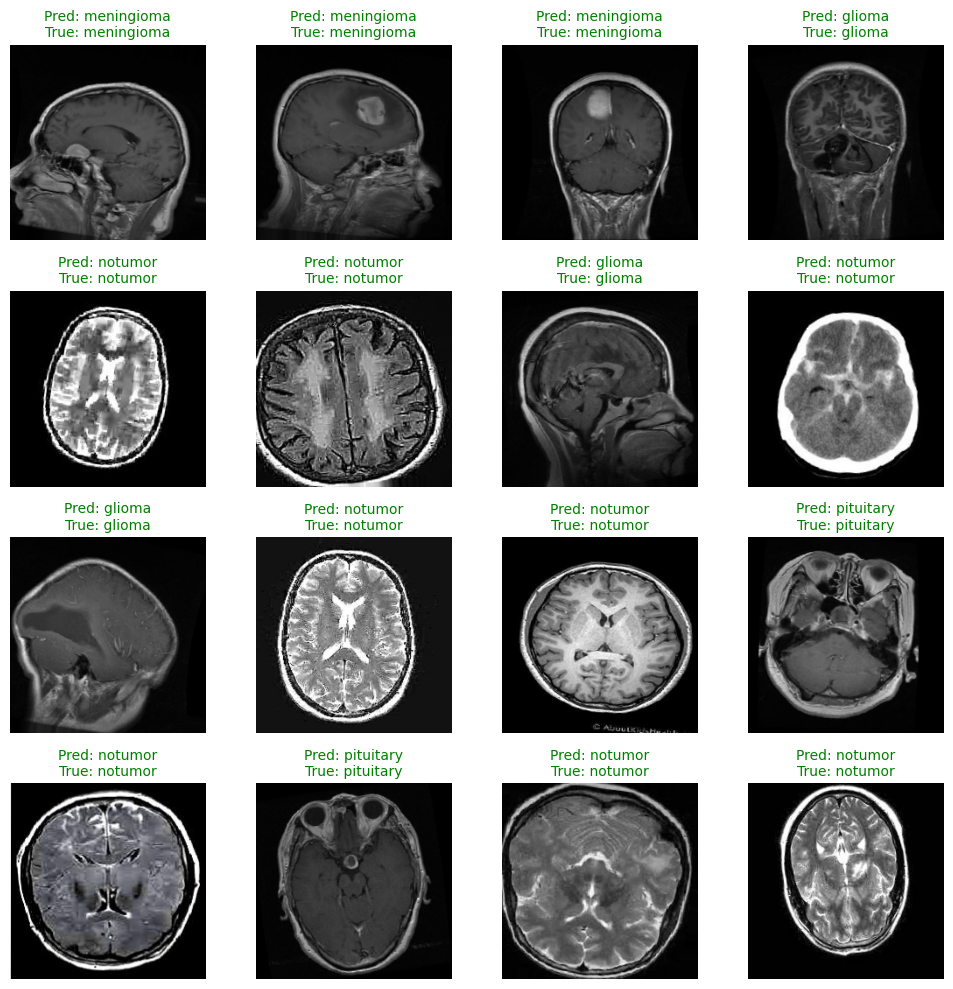

In [50]:

img, label = next(train_genrator)

predictions = model.predict(img)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(label, axis=1)

plt.figure(figsize=(10,10))
for i in range(16):  
    ax = plt.subplot(4,4,i+1)
    plt.imshow(img[i])
    
    
    color = "green" if predicted_labels[i] == true_labels[i] else "red"
    
    plt.title(f"Pred: {class_names[predicted_labels[i]]}\nTrue: {class_names[true_labels[i]]}",
              color=color, fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()


## Using MobileNetV2

In [67]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2 
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import L2



base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


base_model.trainable = False

model_1 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(), 
    layers.Dense(256,activation='relu'), 
    layers.Dense(128,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax') 
])

model_1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_1.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_12          │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_66 (Dense)                     │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_67 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_68 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,619,332 (9.99 MB)

 Trainable params: 361,348 (1.38 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [70]:
checkpoint_path = "best_model_mNet.keras"
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1 )
early_stopping=EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)
Reducel=ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=5,
    verbose=1,
    min_lr=1e-6
)


history = model_1.fit(
    train_genrator,
    epochs=20, 
    validation_data=validation_genrator,
    batch_size=32,
    callbacks=[checkpoint,early_stopping,Reducel]
     )


Epoch 1/20
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.9734 - loss: 0.0750
Epoch 1: val_accuracy improved from -inf to 0.84400, saving model to best_model_mNet.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 58s 389ms/step - accuracy: 0.9733 - loss: 0.0754 - val_accuracy: 0.8440 - val_loss: 0.5801 - learning_rate: 0.0010
Epoch 2/20
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.9685 - loss: 0.0904
Epoch 2: val_accuracy improved from 0.84400 to 0.86152, saving model to best_model_mNet.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 57s 386ms/step - accuracy: 0.9685 - loss: 0.0904 - val_accuracy: 0.8615 - val_loss: 0.5219 - learning_rate: 0.0010
Epoch 3/20
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.9600 - loss: 0.0979
Epoch 3: val_accuracy did not improve from 0.86152
143/143 ━━━━━━━━━━━━━━━━━━━━ 57s 387ms/step - accuracy: 0.9600 - loss: 0.0980 - val_accuracy: 0.8545 - val_loss: 0.5392 - learning_rate: 0.0010
Epoch 4/20
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.

In [71]:
loss, accuracy = model_1.evaluate(validation_genrator)
print(f'Loss: {loss}, Accuracy: {accuracy}')

36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 339ms/step - accuracy: 0.8737 - loss: 0.5052
Loss: 0.533698558807373, Accuracy: 0.8615249991416931


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


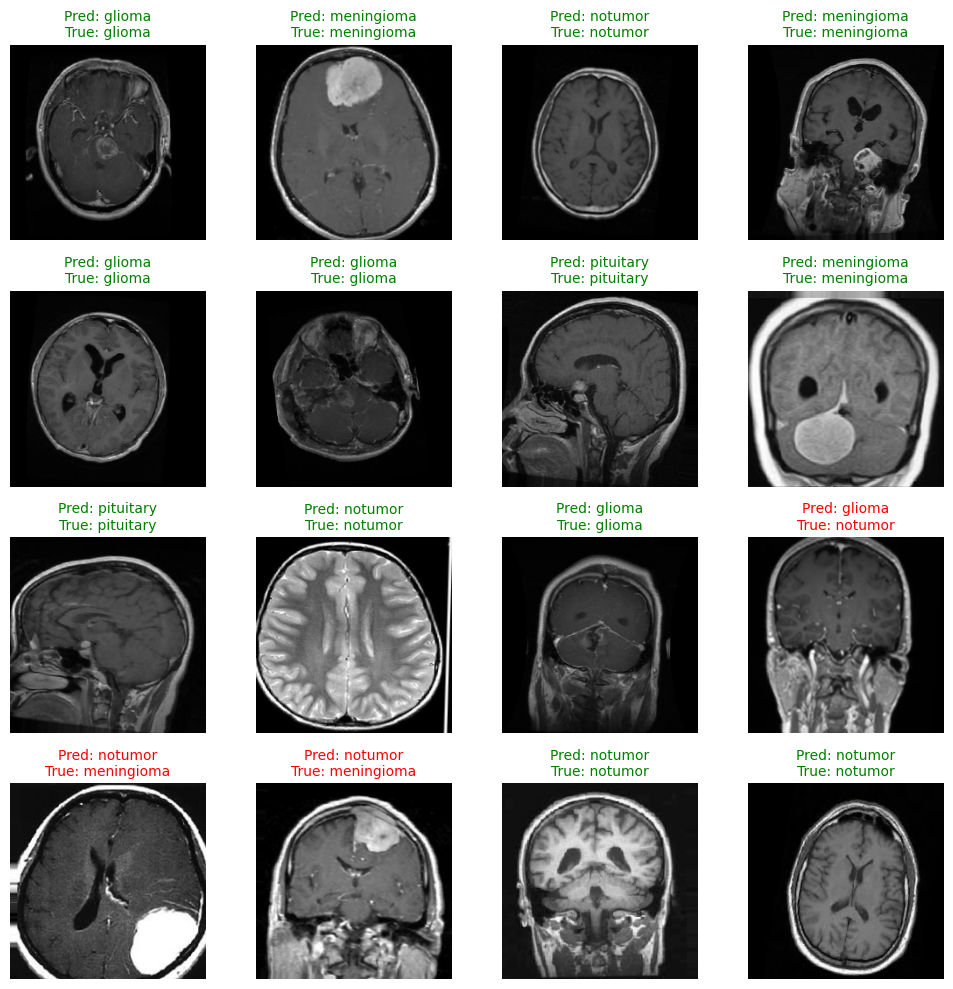

In [77]:

img, label = next(validation_genrator)

predictions = model.predict(img)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(label, axis=1)

plt.figure(figsize=(10,10))
for i in range(16):  
    ax = plt.subplot(4,4,i+1)
    plt.imshow(img[i])
    
    
    color = "green" if predicted_labels[i] == true_labels[i] else "red"
    
    plt.title(f"Pred: {class_names[predicted_labels[i]]}\nTrue: {class_names[true_labels[i]]}",
              color=color, fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()
